# Khushi Subgroup 4 - Bankruptcy Prediction Modeling.

## 1. Importing Libraries

In [1]:
print("Importing libraries")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

import joblib
import warnings
warnings.filterwarnings('ignore')
print("Libraries imported successfully.\n")

Importing libraries
Libraries imported successfully.



## 2. Loading the Cluster 4 Data

In [2]:
df = pd.read_csv('df_cluster_4.csv')
print(f"Cluster 4 data shape: {df.shape}\n")
df.head(10)

Cluster 4 data shape: (1186, 31)



,ROA(C) before interest and depreciation before interest,Operating Expense Rate,Long-term Liability to Current Assets,Inventory/Current Liability,Total expense/Assets,Long-term fund suitability ratio (A),Inventory Turnover Rate (times),Current Asset Turnover Rate,Revenue per person,Research and development expense rate,...,Operating Gross Margin,Cash flow rate,Average Collection Days,Degree of Financial Leverage (DFL),Accounts Receivable Turnover,Net Value Growth Rate,Realized Sales Gross Profit Growth Rate,Cluster,Bankrupt?,Index
0,0.271154,-0.710131,-0.270475,-0.091866,0.933722,2.630791,1.220992,-0.470798,0.106299,-1.203466,...,0.672501,0.945211,-0.097120,-0.119558,-0.153165,-0.003172,-0.071502,4,0,9
1,-0.074437,-0.710025,-0.261282,0.185686,0.377035,0.156614,1.064739,-0.470301,-1.467446,-1.203455,...,2.496470,-0.544932,-0.308210,0.064418,-0.114092,1.519756,-0.040943,4,0,14
2,-0.351847,-0.710112,-0.270475,-0.123686,0.380794,-0.241325,-0.862116,-0.470802,-0.656034,-1.203463,...,0.617445,0.094899,0.251546,-0.119558,-0.191145,-0.151131,-0.071768,4,0,17
3,-0.027826,-0.710138,-0.270475,-0.089767,0.812197,-0.070407,1.220372,-0.470891,-0.515162,-1.203472,...,0.866052,0.483440,-0.271413,-0.115045,-0.122260,-0.079203,-0.080136,4,0,35
4,0.405393,-0.710162,-0.270475,-0.116450,0.562597,-0.640080,1.210143,-0.470868,0.392093,-1.203477,...,0.330922,0.027208,0.306025,-0.101199,-0.195406,-0.075601,-0.064658,4,0,39
5,-0.502686,-0.710160,-0.270475,-0.065443,0.243768,-0.370061,1.214276,-0.470834,-0.544902,-1.203478,...,-0.143270,-0.324854,-0.155056,0.062193,-0.144067,-0.146107,-0.050342,4,0,43
6,-1.094667,-0.710021,-0.270475,-0.055006,0.873883,1.323025,-0.862112,-0.470473,-1.316106,-1.203478,...,0.788694,-1.718717,0.330100,-0.119558,-0.197233,-0.183896,1.180723,4,0,51
7,-1.093115,-0.710090,-0.270475,0.002283,-0.233344,-0.578737,1.221128,-0.470585,-1.338579,-1.203479,...,-0.665511,-0.755186,0.183047,-0.123469,-0.185365,0.104976,0.698789,4,0,52
8,0.427413,-0.710143,-0.270475,-0.191490,0.607147,-0.299825,-0.862115,-0.470835,-0.737159,-1.203475,...,0.853899,0.105645,-0.265840,-0.111151,-0.123470,-0.077682,-0.052616,4,0,61
9,-1.284987,1.409128,-0.270475,3.611300,-1.412924,-0.082209,1.185535,-0.470849,0.240448,-1.203484,...,-1.350734,2.912489,-0.934229,-0.119861,0.531831,-0.220445,-0.291549,4,0,62


## 3. Preparing Features and Target

In [3]:
X = df.drop(columns=['Cluster', 'Bankrupt?', 'Index'])
y = df['Bankrupt?']
print(f"Number of features used: {X.shape[1]}\n")


Number of features used: 28



## 4. Selecting Top 5 Features

In [4]:
print("Selecting Top 5 Features")
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selector.fit(X, y)
top_5_features = pd.Series(rf_selector.feature_importances_, index=X.columns).sort_values(ascending=False).head(5).index.tolist()
X_keep = X[top_5_features]
print("Top 5 Features Selected:")
print(top_5_features)

Selecting Top 5 Features
Top 5 Features Selected:
[' Net Value Growth Rate', ' Total expense/Assets', ' Total debt/Total net worth', ' Current Ratio', ' ROA(C) before interest and depreciation before interest']


## 5. Defining Base Models and Meta Model

### Why These Base Models and Stacking Model Were Chosen

- **Random Forest Classifier:**
  A powerful ensemble method based on decision trees. It reduces overfitting, handles high-dimensional data well,
  and provides feature importance, making it ideal for bankruptcy prediction tasks.

- **K-Nearest Neighbors (KNN):**
  A simple, instance-based learning algorithm that makes predictions based on proximity to neighboring data points.
  It is useful because it makes no assumptions about the underlying data distribution.

- **Gradient Boosting Classifier:**
  An ensemble technique that builds weak learners sequentially to correct errors from previous learners.
  It performs exceptionally well for structured tabular datasets and handles class imbalance with careful tuning.

**Meta-Model:**

- **Logistic Regression:**
  A simple yet effective linear classifier that combines the outputs from base models.
  Logistic regression avoids overfitting and provides strong generalization when using high-quality base model predictions.

Building stacking classifier
Training accuracy (meta-model): 0.929

Number of features used: 5


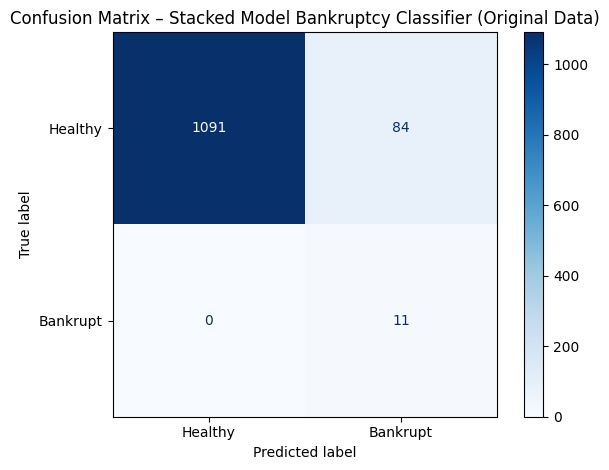

In [5]:
# Define base models
base_models = [
    ('rf', RandomForestClassifier(n_estimators=300, max_depth=10, random_state=42, class_weight = 'balanced')),
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('gb', GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, random_state=42))
]

# Define meta model
meta_model = LogisticRegression(max_iter=1000, random_state=42 , class_weight = 'balanced')

print("Building stacking classifier")
stacking_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=10,
    passthrough=True
)

stacking_clf.fit(X_keep, y)

train_acc_meta = stacking_clf.score(X_keep, y)
print(f"Training accuracy (meta-model): {train_acc_meta:.3f}")

n_features_used = X_keep.shape[1]
print(f"\nNumber of features used: {n_features_used}")

y_pred_full = stacking_clf.predict(X_keep)

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y, y_pred_full,
    display_labels=["Healthy", "Bankrupt"],
    cmap="Blues", values_format="d"
)
plt.title("Confusion Matrix – Stacked Model Bankruptcy Classifier (Original Data)")
plt.tight_layout()
plt.show()


In [6]:
# Print Accuracy score [TT(TF)] for stacked model
acc = accuracy_score(y, y_pred_full)

# Compute TT (true bankrupt predicted bankrupt) and TF (false bankrupt predicted healthy)
TT = ((y == 1) & (y_pred_full == 1)).sum()  # True Bankrupt predicted as Bankrupt
TF = ((y == 1) & (y_pred_full == 0)).sum()  # True Bankrupt predicted as Healthy

# Print final output in your desired format
print(f"\nAccuracy (Meta Model) [TT(TF)]: {acc:.3f} [{TT}({TF})]")


Accuracy (Meta Model) [TT(TF)]: 0.929 [11(0)]


Training accuracy (Random Forest): 1.000 [11(0)]


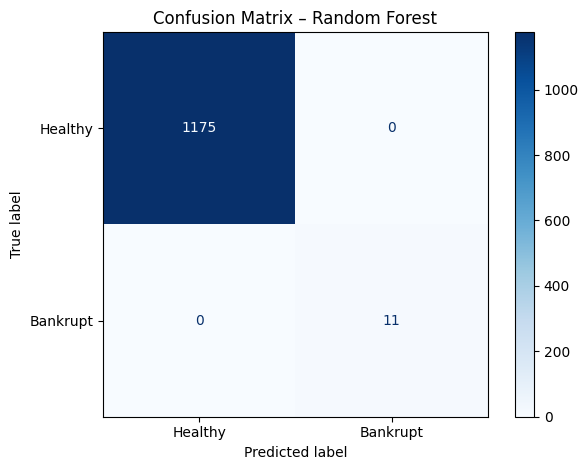

Training accuracy (kNN): 0.991 [0(11)]


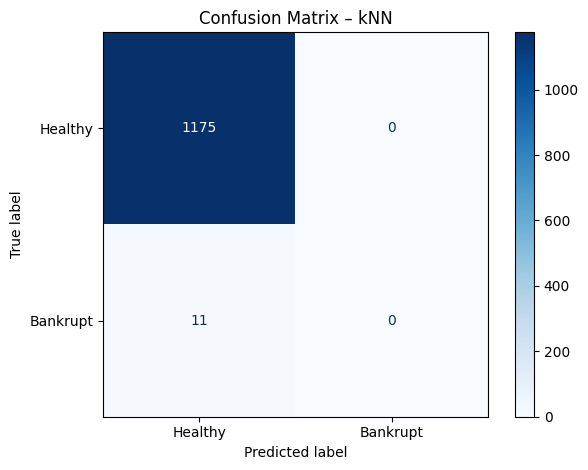

Training accuracy (Gradient Boost): 1.000 [11(0)]


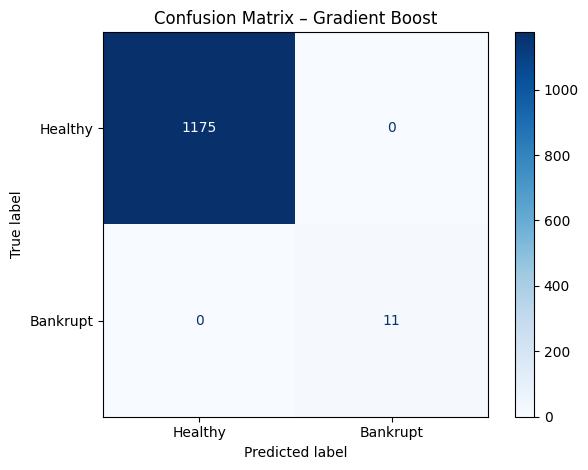


Average training accuracy of base models: 0.997
Average TT(TF): 7.3(3.7)


In [7]:
# Base Models' Avg Accuracy score, [TT(TF)], and Confusion Matrices

base_model_accuracies = []
base_model_TT = []
base_model_TF = []

def evaluate_model(model, X, y, model_name):
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    cm = confusion_matrix(y, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    base_model_accuracies.append(acc)
    base_model_TT.append(tp)
    base_model_TF.append(fn)
    
    print(f"Training accuracy ({model_name}): {acc:.3f} [{tp}({fn})]")
    
    # Plot confusion matrix
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Healthy", "Bankrupt"]).plot(cmap="Blues")
    plt.title(f"Confusion Matrix – {model_name}")
    plt.tight_layout()
    plt.show()

# --- evaluate each base model ---
evaluate_model(stacking_clf.named_estimators_['rf'], X_keep, y, 'Random Forest')
evaluate_model(stacking_clf.named_estimators_['knn'], X_keep, y, 'kNN')
evaluate_model(stacking_clf.named_estimators_['gb'], X_keep, y, 'Gradient Boost')

# --- compute and print average accuracy ---
avg_base_acc = np.mean(base_model_accuracies)
print(f"\nAverage training accuracy of base models: {avg_base_acc:.3f}")

avg_TT = np.mean(base_model_TT)
avg_TF = np.mean(base_model_TF)
print(f"Average TT(TF): {avg_TT:.1f}({avg_TF:.1f})")

## Saving Final Stacking Model

In [8]:
print("\nSaving final stacking model...")
joblib.dump(stacking_clf, 'cluster4_stacking_model.joblib')
print("Model saved successfully as 'cluster4_stacking_model.joblib'.")


Saving final stacking model...
Model saved successfully as 'cluster4_stacking_model.joblib'.


In [9]:
new_train_df = df[[' Net Value Growth Rate', ' Total expense/Assets', ' ROA(C) before interest and depreciation before interest', ' Degree of Financial Leverage (DFL)', ' Total debt/Total net worth']]
joblib.dump(new_train_df, "cluster4_train_data.joblib")
print("Saved selected features to cluster4_train_data.joblib")

Saved selected features to cluster4_train_data.joblib
